# Medical Appointment No Shows Capstone
## Random Forest Model

In [10]:
#Import necessary libraries
import pandas as pd
import numpy as np

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Analysing datetime
from datetime import datetime as dt

# File system manangement
import os,sys

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')



from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [11]:
#MODEL_SELECTION
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#METRICS
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc,explained_variance_score
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

#TREE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz


#Preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

In [4]:
#SCIPY
from scipy.stats import randint

### Load Data

#### OneHotEncoder Data

In [5]:
path = 'data/df_ohe.csv'
df_ohe = pd.read_csv(path, index_col=None) 
df_ohe.sample()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSSent,WaitingDays,ScheduledHour,ScheduledDay_Y,...,AppointmentDayWeekName_5,ScheduledDayMonthName_1,ScheduledDayMonthName_2,ScheduledDayMonthName_3,ScheduledDayMonthName_4,ScheduledDayMonthName_5,ScheduledDayMonthName_6,ScheduledDayMonthName_7,AppointmentDayMonthName_1,AppointmentDayMonthName_2
94517,26,0,0,0,0,0,1,4,7,2016,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Train/Test

In [12]:
X = df_ohe.drop(['NoShow_1'], axis = 1)
y = df_ohe['NoShow_1']

SEED = 42
TS = 0.25

# Create training and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = TS, random_state=SEED, stratify=y)

#Feature Scaling to prevent information leakage
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(82887, 112)
(82887,)
(27630, 112)
(27630,)


___

# Random Forest Classifier

In [37]:
MODEL_PARAMS = {
    "n_estimators": 350,
    "criterion": 'entropy',
    "max_depth": None,
    "min_samples_split":2,
    "min_samples_leaf":1,
    "min_weight_fraction_leaf":0.0,
    "max_features":'auto',
    "max_leaf_nodes":None,
    "min_impurity_decrease":0.0,
    "min_impurity_split":None,
    "bootstrap":True,
    "oob_score":False,
    "n_jobs":None,
    "random_state": SEED,
    "verbose":0,
    "warm_start":False,
    "class_weight":None,
    "ccp_alpha":0.0,
    "max_samples":None,
}

rf = RandomForestClassifier(**MODEL_PARAMS)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]


rf_score = round(rf.score(X_train, y_train) * 100, 2)
rf_test_score = round(rf.score(X_test, y_test) * 100, 2)

print('Random Forest Training Score:', rf_score)
print('Random Forest Test Score:', rf_test_score)


#Checking performance on our model with ROC Score.
rf_roc_score = round(roc_auc_score(y_test,y_pred_proba)*100,3)
print("ROC Score:", rf_roc_score)

RandomForestClassifier(criterion='entropy', n_estimators=350, random_state=42)

Random Forest Training Score: 99.75
Random Forest Test Score: 80.32
ROC Score: 74.899


### ROC curve values: 

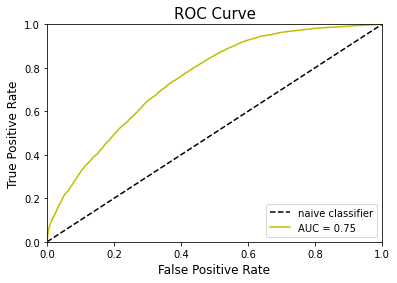

In [38]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr,tpr, thresholds = roc_curve(y_test,y_pred_proba)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--', label='naive classifier')
_ = plt.plot(fpr,tpr, 'y',  label = 'AUC = %0.2f' % roc_auc)

_ = plt.xlim([0, 1])
_ = plt.ylim([0, 1])

_ = plt.legend(prop={'size':10},loc = 'lower right')
_ = plt.xlabel('False Positive Rate', size=12)
_ = plt.ylabel('True Positive Rate', size=12)
_ = plt.title('ROC Curve', size=15)
_ = plt.show()

___

## Hyperparameter tuning with RandomizedSearchCV

In [39]:
n_estimators = [10, 50, 100, 200, 300, 400, 500] 
max_features = ['auto', 'sqrt'] #log2
max_depth = [3, 6, 10, 15, 20] 
criterion = ['gini', 'entropy']
min_samples_leaf = [1,2,3,5,10,15]
min_samples_split = [1,2,3,5,10,15,20]
bootstrap = [True,False]

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "max_features": max_features,
              "min_samples_leaf": min_samples_leaf,
              "min_samples_split": min_samples_split,
              "bootstrap":bootstrap,
              "criterion": criterion}

# Instantiate a Decision Tree classifier: tree
rfc = RandomForestClassifier(random_state=SEED)


# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(rfc, param_dist, scoring="roc_auc", random_state=SEED, cv=10)

# Fit it to the data
tree_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 6, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 5, 10,
                                                             15],
                                        'min_samples_split': [1, 2, 3, 5, 10,
                                                              15, 20],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         400, 500]},
                   random_state=42, scoring='roc_auc')

Tuned Decision Tree Parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}
Best score is 0.7388926152890487


In [32]:
MODEL_PARAMS = {
    "n_estimators": 500,
    "criterion": 'entropy',
    "max_depth": 20,
    "min_samples_split":15,
    "min_samples_leaf":15,
    "min_weight_fraction_leaf":0.0,
    "max_features":'auto',
    "max_leaf_nodes":None,
    "min_impurity_decrease":0.0,
    "min_impurity_split":None,
    "bootstrap":True,
    "oob_score":False,
    "n_jobs":None,
    "random_state": SEED,
    "verbose":0,
    "warm_start":False,
    "class_weight":None,
    "ccp_alpha":0.0,
    "max_samples":None,
}

rf = RandomForestClassifier(**MODEL_PARAMS)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]


rf_score = round(rf.score(X_train, y_train) * 100, 2)
rf_test_score = round(rf.score(X_test, y_test) * 100, 2)

print('Random Forest Training Score:', rf_score)
print('Random Forest Test Score:', rf_test_score)


#Checking performance on our model with ROC Score.
rf_roc_score = round(roc_auc_score(y_test,y_pred_proba)*100,3)
print("ROC Score:", rf_roc_score)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=15,
                       min_samples_split=15, n_estimators=500, random_state=42)

Random Forest Training Score: 79.84
Random Forest Test Score: 79.81
ROC Score: 73.962


## Hyperparameter tuning with GridSearchCV

In [ ]:
n_estimators = [100, 200] 
max_features = ['auto', 'sqrt', 'log2']
max_depth = [3, 6, 10, 15, 20] 
criterion = ['gini', 'entropy']

param_grid = { 
    'n_estimators':n_estimators,
    'max_features': max_features,
    'max_depth' : max_depth,
    'criterion' :criterion,
}

rf = RandomForestClassifier() 

gs_rfc = GridSearchCV(estimator=rf, 
                      param_grid=param_grid, 
                      scoring='roc_auc',
                      cv= 5)

gs_rfc.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(gs_rfc.best_params_))
print("Best score is {}".format(gs_rfc.best_score_))
print(gs_rfc.best_estimator_.get_params())

___

In [38]:
MODEL_PARAMS = {
    "n_estimators": 300,
    "criterion": 'entropy',
    "max_depth": 7,
    "min_samples_split":2,
    "min_samples_leaf":3,
    "min_weight_fraction_leaf":0.0,
    "max_features":3,
    "max_leaf_nodes":None,
    "min_impurity_decrease":0.0,
    "min_impurity_split":None,
    "bootstrap":True,
    "oob_score":False,
    "n_jobs":None,
    "random_state": SEED,
    "verbose":0,
    "warm_start":False,
    "class_weight":None,
    "ccp_alpha":0.0,
    "max_samples":None,
}

rf = RandomForestClassifier(**MODEL_PARAMS)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]



rf_score = round(rf.score(X_train, y_train) * 100, 2)
rf_test_score = round(rf.score(X_test, y_test) * 100, 2)

print('Random Forest Training Score:', rf_score)
print('Random Forest Test Score:', rf_test_score)


#Checking performance on our model with ROC Score.
rf_roc_score = round(roc_auc_score(y_test,y_pred_proba)*100,3)
print("ROC Score:", rf_roc_score)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features=3,
                       min_samples_leaf=3, n_estimators=300, random_state=42)

Random Forest Training Score: 79.81
Random Forest Test Score: 79.81
ROC Score: 70.583


In [ ]:
param_grid = {'n_estimators':np.arange(1,50)}
knn = RandomForestClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

In [39]:
estimator = rf.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = X_train,
                class_names = y_train,
                rounded = True, 
                proportion = False,
                precision = 2, 
                filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook

Image(filename = 'tree.png')

ValueError: Length of feature_names, 82887 does not match number of features, 112

In [9]:
# evaluate each feature's importance
importances = rf.feature_importances_

# sort by descending order of importances
indices = np.argsort(importances)[::-1]

#create sorted dictionary
forest_importances = {}

print("Feature ranking:")
for f in range(X.shape[1]):
    forest_importances[X.columns[indices[f]]] = importances[indices[f]]
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Age (0.177744)
2. WaitingDays (0.110100)
3. ScheduledHour (0.106352)
4. ScheduledDay_D (0.058988)
5. AppointmentDay_D (0.052590)
6. Gender_1 (0.031152)
7. SMSSent (0.014983)
8. Hypertension (0.013085)
9. ScheduledDayWeekDay_4 (0.012907)
10. ScheduledDayWeekDay_5 (0.012667)
11. AppointmentDayWeekName_5 (0.012061)
12. Scholarship (0.012013)
13. AppointmentDayWeekName_4 (0.011714)
14. ScheduledDayMonthName_6 (0.011705)
15. ScheduledDayWeekDay_3 (0.011561)
16. ScheduledDayWeekDay_1 (0.011375)
17. AppointmentDayWeekName_1 (0.011064)
18. AppointmentDayWeekName_3 (0.010377)
19. Neighborhood_37 (0.010225)
20. Neighborhood_42 (0.009399)
21. Diabetes (0.008851)
22. Neighborhood_58 (0.008418)
23. Neighborhood_10 (0.007734)
24. Neighborhood_8 (0.006866)
25. Neighborhood_77 (0.006825)
26. Neighborhood_68 (0.006477)
27. Neighborhood_35 (0.006314)
28. Neighborhood_76 (0.006139)
29. Neighborhood_67 (0.006108)
30. Neighborhood_39 (0.006100)
31. Alcoholism (0.006096)
32. Neighborhood